In [ ]:
!pip install -q streamlit

: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import math

In [6]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/RITESH2127/HOUSE-PRICE-PREDICTION-TOOL/refs/heads/main/housing.csv', header=None, delimiter=r"\s+", names=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [9]:
def plot_all_histograms(df, title_prefix=""):
    num_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = math.ceil(len(num_cols) / n_cols)

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{title_prefix}{col}")
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout()
    plt.show()

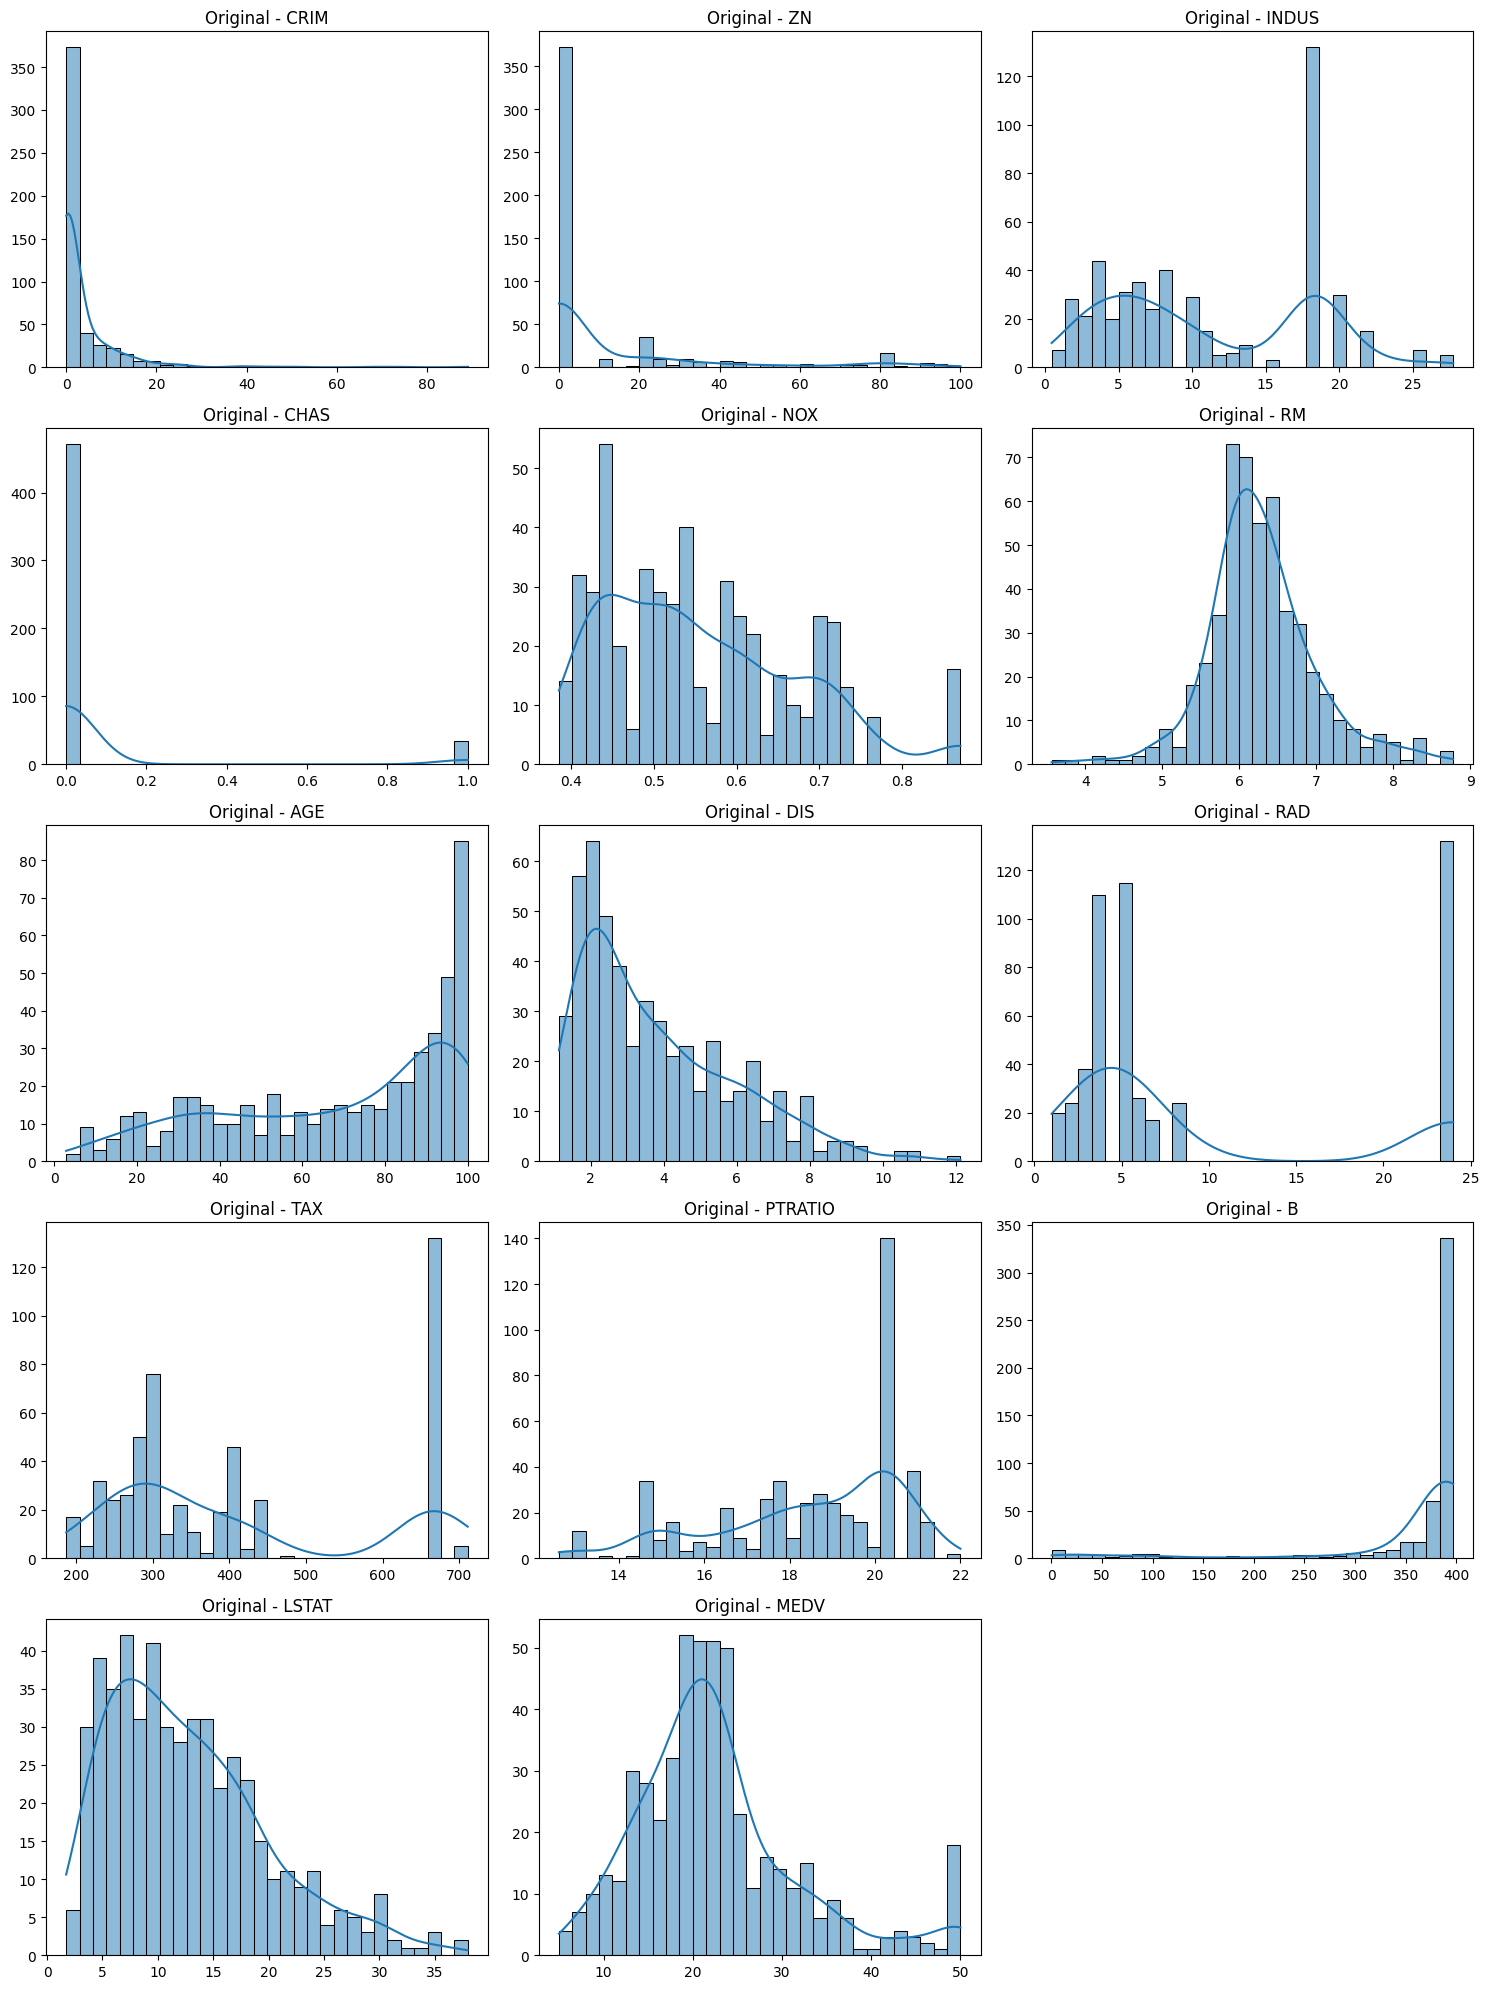

In [10]:
plot_all_histograms(df, title_prefix="Original - ")

In [11]:
from scipy.stats import skew

In [12]:
skews = df.apply(skew).sort_values(ascending=False)
print(skews)

CRIM       5.207652
CHAS       3.395799
ZN         2.219063
MEDV       1.104811
DIS        1.008779
RAD        1.001833
LSTAT      0.903771
NOX        0.727144
TAX        0.667968
RM         0.402415
INDUS      0.294146
AGE       -0.597186
PTRATIO   -0.799945
B         -2.881798
dtype: float64


In [14]:
X = df.drop("MEDV", axis=1)
y = df["MEDV"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
pt = PowerTransformer(method="yeo-johnson")
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

In [17]:
X_train_transformed = pd.DataFrame(
    X_train_transformed, columns=X_train.columns, index=X_train.index
)
X_test_transformed = pd.DataFrame(
    X_test_transformed, columns=X_test.columns, index=X_test.index
)

In [20]:
baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

transformed = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base)

transformed.fit(X_train, y_train)
y_pred_trans = transformed.predict(X_test)
r2_trans = r2_score(y_test, y_pred_trans)
rmse_trans = mean_squared_error(y_test, y_pred_trans)

print({"baseline_R2": r2_base, "baseline_RMSE": rmse_base,
       "transformed_R2": r2_trans, "transformed_RMSE": rmse_trans})

{'baseline_R2': 0.668759493535632, 'baseline_RMSE': 24.291119474973513, 'transformed_R2': 0.7314914118018747, 'transformed_RMSE': 19.690750583605777}


In [22]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        pipe_base = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        pipe_trans = Pipeline([
            ("power", PowerTransformer(method="yeo-johnson")),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        pipe_base.fit(X_train, y_train)
        y_pred_base = pipe_base.predict(X_test)
        r2_base = r2_score(y_test, y_pred_base)
        rmse_base = mean_squared_error(y_test, y_pred_base)

        pipe_trans.fit(X_train, y_train)
        y_pred_trans = pipe_trans.predict(X_test)
        r2_trans = r2_score(y_test, y_pred_trans)
        rmse_trans = mean_squared_error(y_test, y_pred_trans)

        results.append({
            "Model": name,
            "Baseline R2": r2_base,
            "Baseline RMSE": rmse_base,
            "Transformed R2": r2_trans,
            "Transformed RMSE": rmse_trans
        })
    return pd.DataFrame(results)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(random_state=42)
}

results_df = evaluate_models(models, X_train, X_test, y_train, y_test)
results_df

,Model,Baseline R2,Baseline RMSE,Transformed R2,Transformed RMSE
0,LinearRegression,0.668759,24.291119,0.731491,19.690751
1,Ridge,0.668462,24.312904,0.731249,19.708529
2,Lasso,0.650138,25.656739,0.720743,20.478936
3,RandomForest,0.892100,7.912745,0.890932,7.998343


In [23]:
# Find the minimum error across both RMSE columns
results_df["Best_RMSE"] = results_df[["Baseline RMSE", "Transformed RMSE"]].min(axis=1)

# Select the row with the minimum RMSE
best_model_row = results_df.loc[results_df["Best_RMSE"].idxmin()]

# Store model name in a variable
best_model = best_model_row["Model"]

print("Best Model:", best_model)

Best Model: RandomForest


In [24]:
import joblib

joblib.dump(models[best_model], "best_model.pkl")
print("Saved best model to best_model.pkl")


Saved best model to best_model.pkl


In [31]:
%%writefile streamlit_app.py
import streamlit as st
import joblib
import pandas as pd

# Display the image at the top (make sure the file path is correct)
# st.image(r"C:\Users\vishaljeet\Pictures\Camera Roll\py\GAIL.svg.png", width=150)

# Load the saved best model pipeline
try:
    pipeline = joblib.load(r'/content/best_model.pkl')
except FileNotFoundError:
    st.error("Error: 'best_model.pkl' not found. Please ensure the best model is saved.")
    st.stop()

# Define the Streamlit application title and description
st.title("Boston House Price Prediction")
st.write("Enter the details of the house to predict its price.")

# Center the input form using columns with extra space between
st.markdown("## House Features")
outer_col1, outer_col2, outer_col3 = st.columns([1, 2, 1])

with outer_col2:
    left, spacer, right = st.columns([1, 0.3, 1])
    with left:
        crim = st.number_input(
            "CRIM",
            value=0.1,
            format="%f",
            help="Per capita crime rate by town. Typical range: 0.0 - 90.0"
        )
        zn = st.number_input(
            "ZN",
            value=0.0,
            format="%f",
            help="Proportion of residential land zoned for lots over 25,000 sq.ft. Typical range: 0.0 - 100.0"
        )
        indus = st.number_input(
            "INDUS",
            value=7.0,
            format="%f",
            help="Proportion of non-retail business acres per town. Typical range: 0.5 - 27.0"
        )
        chas = st.selectbox(
            "CHAS",
            options=[0, 1],
            help="Charles River dummy variable: 1 if tract bounds river; 0 otherwise"
        )
        nox = st.number_input(
            "NOX",
            value=0.5,
            format="%f",
            help="Nitric oxides concentration (parts per 10 million). Typical range: 0.3 - 0.9"
        )
        rm = st.number_input(
            "RM",
            value=6.0,
            format="%f",
            help="Average number of rooms per dwelling. Typical range: 3.0 - 9.0"
        )
        age = st.number_input(
            "AGE",
            value=60.0,
            format="%f",
            help="Proportion of owner-occupied units built prior to 1940. Typical range: 2.0 - 100.0"
        )
    with right:
        dis = st.number_input(
            "DIS",
            value=4.0,
            format="%f",
            help="Weighted distances to five Boston employment centres. Typical range: 1.0 - 13.0"
        )
        rad = st.number_input(
            "RAD",
            value=1.0,
            format="%f",
            help="Index of accessibility to radial highways. Typical range: 1.0 - 24.0"
        )
        tax = st.number_input(
            "TAX",
            value=300.0,
            format="%f",
            help="Full-value property-tax rate per $10,000. Typical range: 187.0 - 711.0"
        )
        ptratio = st.number_input(
            "PTRATIO",
            value=18.0,
            format="%f",
            help="Pupil-teacher ratio by town. Typical range: 12.0 - 22.0"
        )
        b = st.number_input(
            "B",
            value=390.0,
            format="%f",
            help="1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town. Typical range: 0.0 - 400.0"
        )
        lstat = st.number_input(
            "LSTAT",
            value=12.0,
            format="%f",
            help="% lower status of the population. Typical range: 1.0 - 38.0"
        )

    # Add a button to trigger prediction
    if st.button("Predict House Price"):
        input_data = pd.DataFrame([[crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, b, lstat]],
                                  columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
        try:
            predicted_price = pipeline.predict(input_data)[0]
            st.success(f"The predicted house price is: ${predicted_price:.2f}")
        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")

Writing streamlit_app.py


In [33]:
!streamlit run streamlit_app.py
# !streamlit run streamlit_app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://104.197.92.169:8501

  Stopping...
  Stopping...
